# Sample selection
Sample selection needs to balance two competing issues:
(a) the size of the image needs to be large enough that there is a useful range of floe sizes that can be resolved
(b) the number of scenes should be large enough that we can consider it a representative random sample
Because the time needed to manually annotate an image is proportional to the image area, the number of images that can be analyzed is strongly limited by the image size. 

First, nine regions spanning the circumpolar Arctic seasonal ice zones were selected (Figure 1, Table 1). The regions were selected to have equal area. The file `setup_locations.py` makes a CSV file `data/metadata/region_definitions.csv`.

We perform stratified random sampling to select a set of images for the validation dataset.
We use the NSIDC Sea Ice Concentration Climate Data Record (SIC CDR) to identify periods of time that each region contains some overlap with the sea ice region. We acknowledge that uncertainty in SIC CDR is high during the summer. Since the purpose of using the SIC CDR in the random sampling is to find a wide range of sea ice conditions, rather than to make inferences about sea ice physics in these regions, we consider the SIC CDR suitable for this purpose.

Within each region, we follow the following procedure
* Randomly choose a start year and a date between March and region-specific end date (max September 30)
* Select a center point (x, y) that is at least 250 km from the border
* Calculate sea ice fraction for the point
* If the sea ice fraction is at least 0.25, add date and center point to list of cases
* Check the number of cases.
   * If the minimum number of cases per month is met, move to the next region.
    
We start by generating a set of samples larger than is needed for the validation dataset, saving 10 candidate cases per month, per region. We then stratify the sample to get minimum 3 samples per month, with randomly chosen additional samples chosen to bring the number to 21 dates per region for locations where sea ice is present less than 7 months of the summer.

## Get start and end dates from the SIF data

In [334]:
import os
import pyproj
import numpy as np
import pandas as pd
import xarray as xr

In [335]:
sif_data = pd.read_csv('../data/metadata/daily_sea_ice_fraction.csv', index_col=0, parse_dates=True)
regions = pd.read_csv('../data/metadata/region_definitions.csv', index_col='region')
threshold = 0.05
end_doy = sif_data.groupby(sif_data.index.dayofyear).quantile(0.90).apply(lambda x: x[x >= threshold].index.max())
start_doy = pd.Series(pd.to_datetime('2003-03-01').dayofyear, index=end_doy.index)

In [336]:
# regions.merge(end_doy, left_index=True, right_index=True)
regions.loc[end_doy.index, 'end_doy'] = end_doy.values
regions.loc[start_doy.index, 'start_doy'] = start_doy.values
regions.loc[start_doy.index, 'start_mmdd'] = (pd.to_timedelta(regions['start_doy'] - 1, unit='D') + pd.to_datetime('2001-01-01 00:00')).dt.strftime('%b %d')
regions.loc[end_doy.index, 'end_mmdd'] = (pd.to_timedelta(regions['end_doy'] - 2, unit='D') + pd.to_datetime('2001-01-01 00:00')).dt.strftime('%b %d')
regions.sort_values('center_lon').loc[:, ['start_doy', 'end_doy', 'start_mmdd', 'end_mmdd']].to_csv('../data/metadata/sample_start_end_times.csv')

In [337]:
regions.loc[:, ['center_lat', 'center_lon', 'start_mmdd', 'end_mmdd']]

,center_lat,center_lon,start_mmdd,end_mmdd
region,,,,
baffin_bay,75,-65,Mar 01,Sep 30
barents-kara_seas,75,54,Mar 01,Sep 29
beaufort_sea,75,-135,Mar 01,Sep 30
bering_strait,65,-170,Mar 01,Aug 10
chukchi-east_siberian_sea,75,166,Mar 01,Sep 30
greenland_sea,77,-10,Mar 01,Sep 30
hudson_bay,60,-83,Mar 01,Aug 19
laptev_sea,75,125,Mar 01,Sep 30
sea_of_okhostk,58,148,Mar 01,Jun 26


## Generate large random sample prior to stratification
These functions carry out the random sampling and sea ice fraction checks.

In [338]:
sic_dataloc = '/Users/dwatkin2/Documents/research/data/nsidc_daily_cdr/'
def compute_sic(left_x, right_x, bottom_y, top_y, sic_data):
    """Computes the sea ice extent as a fraction of total area within the region bounded
    by <left_x>, <right_x>, <bottom_y>, and <top_y> using the netcdf file <sic_data>. Assumes
    that sic_data is the NSIDC SIC CDR."""

    x_idx = (sic_data.xgrid >= left_x) & (sic_data.xgrid <= right_x)
    y_idx = (sic_data.ygrid >= bottom_y) & (sic_data.ygrid <= top_y)
    
    with_ice = ((sic_data.sel(x=x_idx, y=y_idx)['cdr_seaice_conc'] > 0.15) & \
                (sic_data.sel(x=x_idx, y=y_idx)['cdr_seaice_conc'] <= 1))
    coast_mask = (sic_data.sel(x=x_idx, y=y_idx)['cdr_seaice_conc'] > 1).sum() 
    total_area_pixels = np.prod(with_ice.shape)
    sic_area_pixels = with_ice.sum().data
    sic_mean = (sic_data.sel(x=x_idx, y=y_idx).where(with_ice))['cdr_seaice_conc'].mean().data
    return {'sea_ice_fraction': np.round(sic_area_pixels/(total_area_pixels - coast_mask.data), 3),
            'mean_sea_ice_concentration': np.round(sic_mean, 3)}

def find_candidates(n_samples, region_info, dx, sic_path,
                    sif_threshold=0.25, margin=250, start_year=2003, end_year=2022,
                    min_samples_per_month=10):
    """Generates a list of candidate locations for the validation dataset. Initial samples were selected using the
    same steps as shown here. This function places the steps in one place for convenience, and implements a correction
    to the SIC calculation used in the initial version.
    
    n: sets the number of candidates to generate.
    region_info: a row from the region_definitions table. Must include start_doy and end_doy.
    dx is the dimension in km of the sample scene.
    sic_path: path to folder with the NSIDC CDR data.
    sif_threshold: between 0 and 1. The ice fraction needed to retain a sample.
    margin: distance in km that the center needs to be from the edge of the region boundary.
    """
    
    dx_meters = dx*1e3
    region = region_info.name
    start_doy = region_info.start_doy
    end_doy = region_info.end_doy
    left_x = region_info.left_x
    right_x = region_info.right_x
    lower_y = region_info.lower_y
    upper_y = region_info.top_y

    # calculations are done in polar stereographic
    # use pyproj to convert back to lon/lat for final table
    crs0 = pyproj.CRS('WGS84')
    crs1 = pyproj.CRS('epsg:3413')
    transformer_ll = pyproj.Transformer.from_crs(crs1, crs_to=crs0, always_xy=True)
    
    # we keep track of the number of samples generated per month
    # the range is set up this way so that we don't get extra months in 
    # leap years. For other uses the start and end doy could be adjusted differently.
    start_month = (pd.to_datetime('2000-01-01') + pd.to_timedelta(start_doy, unit='d')).month
    end_month = (pd.to_datetime('2000-01-01') + pd.to_timedelta(end_doy - 1, unit='d')).month
    samples_by_month = pd.Series(0, index=np.arange(start_month, end_month+1))
    candidates = []
    
    def in_box(x, y, margin):
        """Convenience function that checks whether point x, y is in region.
        Returns True if x, y in the box."""
        if left_x <= x:
            if right_x >= x:
                if lower_y <= y:
                    if upper_y >= y:
                        return True
        return False
    
    while np.any(samples_by_month < min_samples_per_month):
        # Randomly select date from months with not enough samples
        year = np.random.choice(np.arange(start_year, end_year+1))
        remaining_months = list(samples_by_month[samples_by_month < min_samples_per_month].index)
        month = np.random.choice(remaining_months)
        days_in_month = pd.to_datetime(str(year) + '-' + str(month) + '-01').daysinmonth
        day = np.random.choice(np.arange(1, days_in_month+1))
        date = str(year) + str(month).zfill(2) + str(day).zfill(2)
        
        # Load SIC data for the date. If any MIZ regions, randomly select center point
        # with sea ice concentration between 15 and 85 percent, otherwise pass    
        min_ice = 0.15
        max_ice = 0.85
        
        files = os.listdir(sic_path + str(year))
        if 'f17' in files[0]:
            f = 'seaice_conc_daily_nh_' + date + '_f17_v04r00.nc'
        else:
            f = 'seaice_conc_daily_nh_' + date + '_f13_v04r00.nc'
            
        with xr.open_dataset(sic_dataloc + str(year) + '/' + f) as sic_data:
            # generate center point
            X, Y = np.meshgrid(sic_data.xgrid, sic_data.ygrid)
            miz = (sic_data['cdr_seaice_conc'] >= min_ice) & (sic_data['cdr_seaice_conc'] <= max_ice)
            miz = np.ravel(miz.squeeze())
            xoptions = np.ravel(X)[miz]
            yoptions = np.ravel(Y)[miz]
            inside = np.array([in_box(x, y, margin) for x, y in zip(xoptions, yoptions)])
    
            if np.any(inside):
                ii = np.random.choice(np.arange(len(xoptions))[inside])
                
                # get x, y coordinates
                x0 = xoptions[ii]
                y0 = yoptions[ii]

                # define scene centered at x0, y0
                left_x0 = x0 - dx_meters/2
                right_x0 = x0 + dx_meters/2
                lower_y0 = y0 - dx_meters/2
                upper_y0 = y0 + dx_meters/2
                
                sic_results = compute_sic(left_x0, right_x0, lower_y0, upper_y0, sic_data)
                # check SIF threshold
                if sic_results['sea_ice_fraction'] >= sif_threshold:
                    lon0, lat0 = transformer_ll.transform(x0, y0)
                    candidates.append([region, pd.to_datetime(date).strftime('%Y-%m-%d'),
                                       lon0, lat0, x0, y0, sic_results['sea_ice_fraction'],
                                       sic_results['mean_sea_ice_concentration']])
                    samples_by_month[month] += 1

    candidates = pd.DataFrame(candidates,
            columns=['region', 'start_date', 'center_lon', 'center_lat',
                     'center_x', 'center_y', 'sea_ice_fraction', 'mean_sea_ice_concentration'])

    candidates['month'] = pd.to_datetime(candidates['start_date'].values).month
    return candidates

## Selecting additional cases
The original run of the random sample algorithm included cases with overestimated sea ice fraction. We run the sampling again to replace these cases. Additionally, we calculate the corrected sea ice fraction.

In [345]:
candidates = []
for name, row in regions.iterrows():
    candidates.append(find_candidates(n_samples=100,
                region_info=row,
                dx=100,
                sic_path=sic_dataloc,
                sif_threshold=0.25,
                margin=250, start_year=2003, end_year=2022,
                min_samples_per_month=20))
candidates = pd.concat(candidates)    

This section takes the original version of the candidate case dataset, re-calculates the SIC, and adds new candidate samples that pass the criteria for start time and for sea ice fraction.

In [354]:
# Take original random sample with SIC error, drop the cases with < 0.25 sea ice fraction
# Drop the samples from outside each regions time window
sic_dataloc = '/Users/dwatkin2/Documents/research/data/nsidc_daily_cdr/'
candidate_validation_table = pd.read_csv('../../data/candidate_validation_table.csv', index_col=0)
candidate_validation_table['start_date'] = pd.to_datetime(candidate_validation_table['start_date'].values)
candidate_validation_table.drop('ice_frac', inplace=True, axis=1)
for idx, row in candidate_validation_table.iterrows():
    year = row.start_date.year
    files = os.listdir(sic_dataloc + str(year))
    if 'f17' in files[0]:
        f = 'seaice_conc_daily_nh_' + row.start_date.strftime('%Y%m%d') + '_f17_v04r00.nc'
    else:
        f = 'seaice_conc_daily_nh_' + row.start_date.strftime('%Y%m%d') + '_f13_v04r00.nc'
    dx = 100e3
    left_x = row.center_x - dx/2
    right_x = row.center_x + dx/2
    bottom_y = row.center_y - dx/2
    top_y = row.center_y + dx/2
    with xr.open_dataset(sic_dataloc + str(year) + '/' + f) as sic_data:
        sic_results = compute_sic(left_x, right_x, bottom_y, top_y, sic_data)
        candidate_validation_table.loc[idx, 'sea_ice_fraction'] = sic_results['sea_ice_fraction']
        candidate_validation_table.loc[idx, 'mean_sea_ice_concentration'] = sic_results['mean_sea_ice_concentration']

In [355]:
# Make a column "keep" that is only true if the start date is in the right
# window and if the sea ice fraction is at least 0.25.
passing_candidates = candidate_validation_table.loc[candidate_validation_table['sea_ice_fraction'] >= 0.25].copy()     
passing_candidates['start_doy'] = passing_candidates['start_date'].dt.dayofyear
passing_candidates['keep'] = True
for region, group in passing_candidates.groupby('region'):
    passing_candidates.loc[group.index, 'keep'] = group['start_doy'] <= regions.loc[region, 'end_doy']

# Add more samples to the mix where there are less than 10 passing samples per month
min_per_month = 10
new_sample_list = []
for (region, month), group in passing_candidates.groupby(['region', 'month']):
    n_samples = group['keep'].sum()
    if n_samples < min_per_month:
        # check available sample dates
        # will have length zero if nothing available past the last date DOY
        new_samples = candidates.loc[(candidates['region'] == region) & (candidates['month'] == month),:]
        new_samples = new_samples.loc[
            pd.to_datetime(new_samples['start_date']).dt.dayofyear < regions.loc[region, 'end_doy']]
        if len(new_samples) > 0:
            new_sample_list.append(new_samples.sample(min_per_month - n_samples))

In [356]:
# Concatenate the dataframes
new_samples = pd.concat(new_sample_list)
for c in passing_candidates:
    if c not in new_samples.columns:
        new_samples[c] = np.nan
new_samples['keep'] = True
new_samples = new_samples.loc[:, passing_candidates.columns].copy()
updated_candidates = pd.concat(objs=[passing_candidates, new_samples], join='outer', axis=0).reset_index(drop=True)

In [359]:
# Sort and reindex
updated_candidates['datetemp'] = pd.to_datetime(updated_candidates['start_date'])
updated_candidates['start_date'] = [d.strftime('%Y-%m-%d') for d in updated_candidates['datetemp']]
updated_candidates['start_doy'] = [d.dayofyear for d in updated_candidates['datetemp']]
updated_candidates = updated_candidates.sort_values(['region', 'datetemp']).drop('datetemp', axis=1)
updated_candidates.reset_index(drop=True, inplace=True)

In [364]:
# Get the case numbers that were initially used
all_cases = pd.read_csv('../data/metadata/case_list.csv', index_col=0)
all_cases.reset_index(inplace=True)
all_cases['case_number'] = all_cases['case_number'].astype(int)
all_cases = all_cases.loc[all_cases.satellite=='aqua'] # only looking at one day at a time

updated_candidates['case_number'] = 'NA'
for idx, case_data in all_cases.iterrows():
    uc_idx = (updated_candidates['region'] == case_data.region) & (updated_candidates['start_date'] == case_data.start_date)
    if len(updated_candidates[uc_idx]) == 1:
        updated_candidates.loc[uc_idx, 'case_number'] = str(case_data.case_number).zfill(3)
    else:
        xdiff = updated_candidates['center_x'] - case_data.center_x
        ydiff = updated_candidates['center_y'] - case_data.center_y
        uc_idx = uc_idx & ((np.abs(xdiff) < 1) & (np.abs(ydiff) < 1))
        if len(updated_candidates[uc_idx]) == 1:
            updated_candidates.loc[uc_idx, 'case_number'] = str(case_data.case_number).zfill(3)

In [365]:
# Assign case numbers to samples in cases where there are less than 3 samples in a month
min_per_month = 3
new_sample_list = []
start_new_idx = np.max([int(x) for x in updated_candidates['case_number'] if x != 'NA']) + 1
for (region, month), group in updated_candidates.groupby(['region', 'month']):
    n_samples = (group['case_number'] != 'NA').sum()
    if n_samples < min_per_month:
        # check available sample dates
        # needs to be unassigned (case number is NA)
        # will have length zero if nothing available past the last date DOY
        new_samples = group.loc[(pd.to_datetime(group['start_date']).dt.dayofyear < regions.loc[region, 'end_doy']) & \
                                 (group['case_number'] == 'NA'), :]
        
        if len(new_samples) > 0:
            new_sample_list = new_samples.sample(min_per_month - n_samples)
            for idx in new_sample_list.index:
                updated_candidates.loc[idx, 'case_number'] = str(start_new_idx).zfill(3)
                start_new_idx += 1

In [367]:
# for sites with less than 21 total dates, randomly draw from the 
# remaining unassigned dates, weighting the samples by the number 
# available per month
sample_size = 21
num_samples = updated_candidates.loc[updated_candidates.keep & (updated_candidates.case_number != 'NA')].groupby('region').count()['start_date']
start_new_idx = np.max([int(x) for x in updated_candidates['case_number'] if x != 'NA']) + 1

for region, group in updated_candidates.loc[
    (updated_candidates.case_number == 'NA') & updated_candidates.keep].groupby('region'):
    if num_samples[region] < sample_size:
        n = group.groupby('month').transform('count')['region']
        w = n/np.sum(n)
        new_samples = group.sample(sample_size - num_samples[region], weights=w)
        for idx in new_samples.index:
            updated_candidates.loc[idx, 'case_number'] = str(start_new_idx).zfill(3)
            start_new_idx += 1

In [371]:
case_list = updated_candidates.loc[(updated_candidates.case_number != 'NA') & updated_candidates.keep].copy()
case_list.drop('keep', axis=1, inplace=True)

In [374]:
columns_order = ['case_number', 'region', 'start_date', 'center_lon', 'center_lat', 'center_x',
                 'center_y', 'month', 'sea_ice_fraction', 'mean_sea_ice_concentration', 'start_doy']
case_list.loc[:, columns_order].to_csv('../data/metadata/validation_dataset_case_list.csv', index=False)
updated_candidates.loc[updated_candidates.keep, columns_order].to_csv('../data/metadata/candidate_case_list.csv', index=False)

In [3]:
import proplot as pplt
import pandas as pd
import warnings
import cartopy.crs as ccrs
import numpy as np

case_list = pd.read_csv('../data/metadata/validation_dataset_case_list.csv')
case_list['start_date'] = pd.to_datetime(case_list['start_date'])

# Selected samples
Generate a map showing the location of the selected cases.

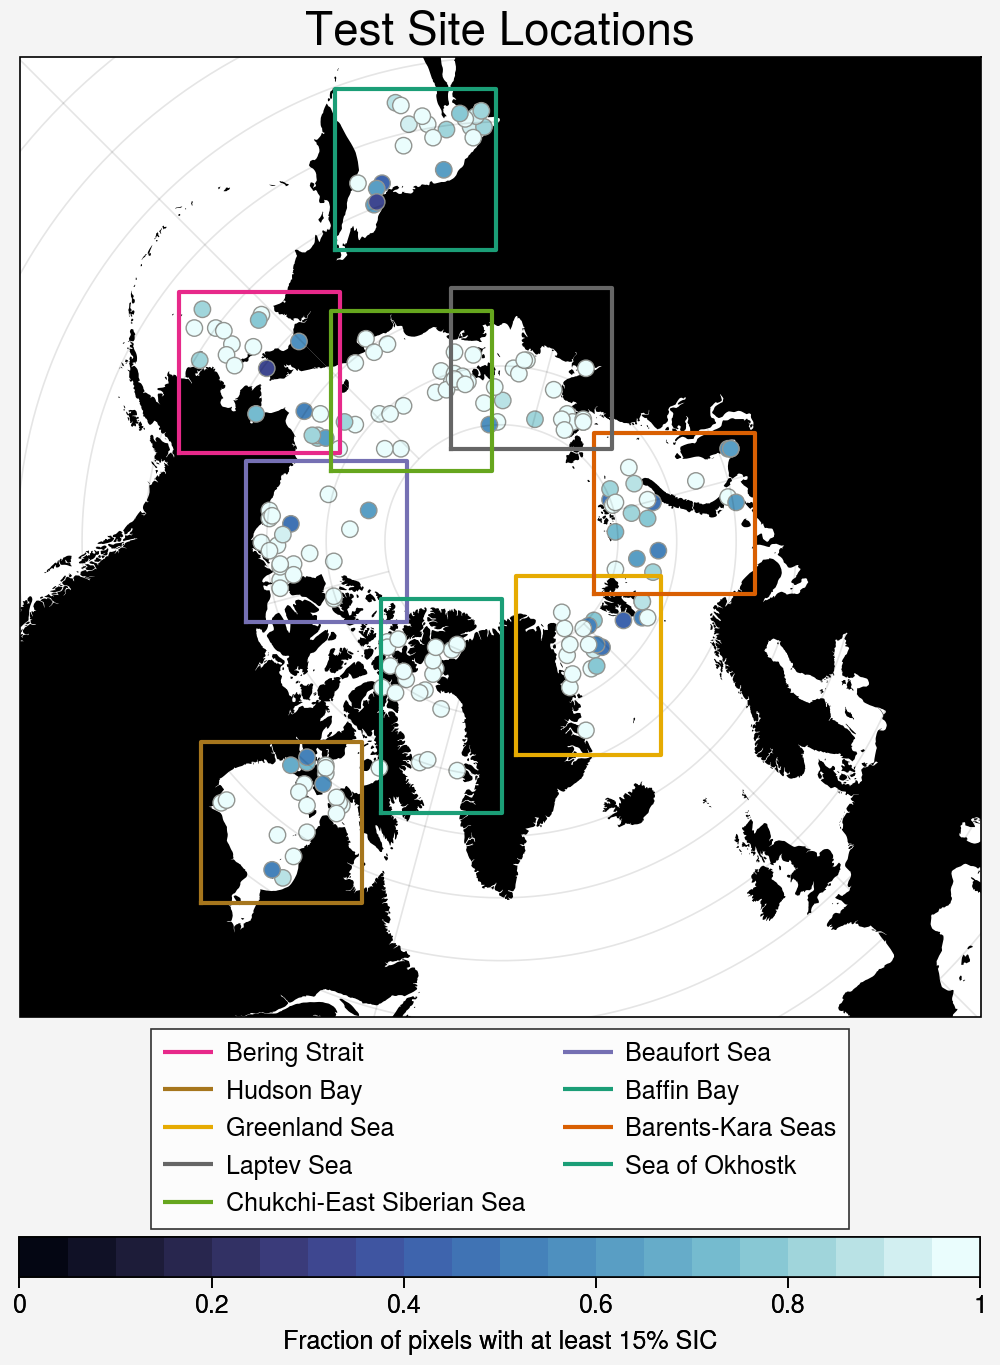

In [4]:
warnings.simplefilter('ignore')
pplt.rc['reso'] = 'med'
regions = pd.read_csv('../data/metadata/region_definitions.csv', index_col=0)

pplt.rc['reso'] = 'med'
pplt.rc['cartopy.circular'] = False

colors = {region: c['color'] for region, c in zip(
            regions.index,
            pplt.Cycle('dark2', len(regions)))}
linestyles = {region: ls for region, ls in zip(regions.index,
                        ['-', '-.', '--', '-', '-.', '--', '-.', '-', '--'])}

regions['print_title'] = [c.replace('_', ' ').title().replace('Of', 'of') for c in regions.index]
regions = regions.sort_values('center_lon')

fig, ax = pplt.subplots(width=5, proj='npstere', proj_kw={'lon_0': -45})
ax.format(land=True, color='k', boundinglat=50, landzorder=0)
h, l = [],[]
for region, lat, lon in zip(regions.index, 
                                 regions.center_lat, regions.center_lon):
    xbox = np.array(regions.loc[region, ['left_x', 'left_x', 'right_x', 'right_x', 'left_x']].astype(float))
    ybox = np.array(regions.loc[region, ['lower_y', 'top_y', 'top_y', 'lower_y', 'lower_y']].astype(float))
    

    ax.plot(xbox, ybox, ls='-', m='', color=colors[region], zorder=5,
            transform=ccrs.CRS('epsg:3413'), label=regions.loc[region, 'print_title'])  
# ax.legend(loc='b')
c = ax.scatter(case_list['center_x'], case_list['center_y'], c=case_list['sea_ice_fraction'],
           ms=35, m='o', transform=ccrs.CRS('epsg:3413'), label='',
               vmin=0, vmax=1, cmap='ice', edgecolor='gray', ew=0.5, N=20)
ax.legend(loc='b', ncols=2)
ax.colorbar(c, loc='b', label='Fraction of pixels with at least 15% SIC')
ax.format(title='Test Site Locations', fontsize=15)
# fig.save('../figures/location_map_example_sites.jpg', dpi=300)